In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "../datasets/mnist/mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

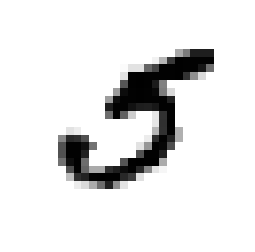

5.0

In [4]:
X, y = mnist['data'], mnist['target']
some_digit = X[36000]

def plot_digit(some_digit):
    some_digit_img = some_digit.reshape(28, 28)
    plt.imshow(some_digit_img, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

plot_digit(some_digit)
y[36000]

In [5]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
shuffle_idx = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

In [6]:
# Training Stochastic Gradient Descent classifier for digit 5.
from sklearn.linear_model import SGDClassifier

y_train5 = (y_train == 5) # True for all 5s, False for all other digits
y_test5 = (y_test == 5)
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train5)
sgd.predict([some_digit])

array([ True], dtype=bool)

In [7]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_train, y_train5, cv=3, scoring='accuracy')

array([ 0.96505,  0.9665 ,  0.96135])

In [8]:
# Confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train5_preds = cross_val_predict(sgd, X_train, y_train5, cv=3)
confusion_matrix(y_train5, y_train5_preds)

array([[54065,   514],
       [ 1628,  3793]])

In [9]:
# Precision, recall, f1 score
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train5, y_train5_preds))
print(recall_score(y_train5, y_train5_preds))
print(f1_score(y_train5, y_train5_preds))

0.880659391688
0.699686404722
0.779810855263


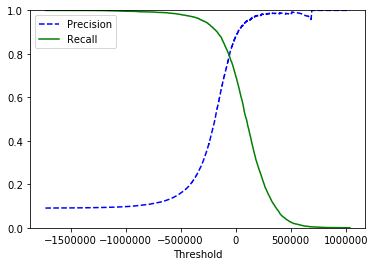

In [10]:
# Figure out the best threshold for precision/recall trade-off.
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd, X_train, y_train5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train5, y_scores)

def plot_precision_recall_vs_threshold(p, r, t):
    plt.plot(t, p[:-1], 'b--', label='Precision')
    plt.plot(t, r[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

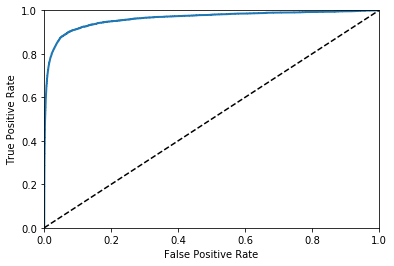

0.96256540467789409

In [11]:
# Receiver Operating Characteristic (ROC) curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

roc_auc_score(y_train5, y_scores) # area under the curve (AUC)

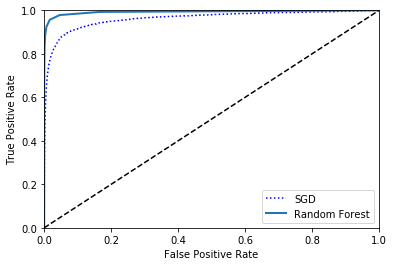

0.99280201392247824

In [12]:
# Compare Random Forest to Stochastic Gradient Descent.
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
y_prob_rfc = cross_val_predict(rfc, X_train, y_train5, cv=3, method='predict_proba')
y_scores_rfc = y_prob_rfc[:, 1]

fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_train5, y_scores_rfc)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_rfc, tpr_rfc, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

roc_auc_score(y_train5, y_scores_rfc)

In [13]:
# Multiclass classification: One vs. One and One vs. All strategies
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

sscaler = StandardScaler()
X_train_scaled = sscaler.fit_transform(X_train.astype(np.float64))

sgd = SGDClassifier(random_state=42) # a binary classifier
sgd.fit(X_train_scaled, y_train) # sklearn automatically uses OvA
print(sgd.decision_function(sscaler.transform([some_digit])))

rfc = RandomForestClassifier(random_state=42) # a multiclass classifier
rfc.fit(X_train_scaled, y_train)
print(rfc.predict_proba(sscaler.transform([some_digit])))

ovoc = OneVsOneClassifier(SGDClassifier(random_state=42))
ovoc.fit(X_train_scaled, y_train)
len(ovoc.estimators_)

[[ -538.24884825 -1143.42085049  -909.96988358  -408.66833792
  -1206.41902107   -20.28042721 -1692.74265535 -1057.34041599
  -2262.54037507 -1907.31762991]]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


45

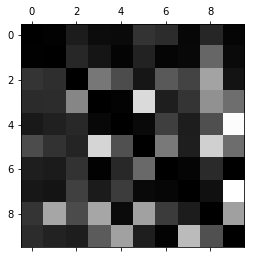

In [14]:
# Error analysis
y_train_preds = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_preds)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0) # scale the errors to lighter colors

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [15]:
# Multilabel classification
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)
print(knn.predict([some_digit]))

#knn_preds = cross_val_predict(KNeighborsClassifier(), X_train, y_multilabel, cv=3)
#f1_score(y_multilabel, knn_preds, average='weighted') # weight each label with its support

[[False  True]]


In [81]:
# Exercise 2: Shift image one pixel to 4 directions, train on the expanded dataset;
# measure its accuracy on the test set.
from scipy.ndimage.interpolation import shift

def insert_shifted_imgs(dataset, labels):
    X_augmented = dataset.copy()
    y_augmented = labels.copy()
    shifted_imgs = []
    shifted_img_lbls = []

    for i in range(len(X_augmented)):
        img = X_augmented[i]
        for y, x in [(-1, 0), (0, -1), (1, 0), (0, 1)]:
            shifted_img = shift(img.reshape(28, 28), [y, x])
            shifted_imgs.append(shifted_img.reshape(784,))
        shifted_img_lbls.extend([y_augmented[i]] * 4)
    
    idxs = np.random.randint(0, len(X_augmented), (len(shifted_imgs),))
    X_augmented = np.insert(X_augmented, idxs, shifted_imgs, axis=0)
    y_augmented = np.insert(y_augmented, idxs, shifted_img_lbls, axis=0)
    
    return X_augmented, y_augmented


X_augmented, y_augmented = insert_shifted_imgs(X_train, y_train)
len(X_augmented), len(y_augmented)

(300000, 300000)

In [83]:
from sklearn.metrics import accuracy_score

sgd_aug = SGDClassifier(random_state=42)
sgd_aug.fit(X_augmented, y_augmented)
sgd_preds = sgd_aug.predict(X_test)
accuracy_score(y_test, sgd_preds)

0.84589999999999999